# G-Research Financial Forecasting Challenge

In [50]:
# 
# Author: Italo Balestra <italobale@gmail.com>

"""
Analysis of data of the G-Research Financial Forecasting Challenge.
"""

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from xgboost import XGBRegressor, plot_importance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score 
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV 
import matplotlib.pyplot as plt

# Global Variables
seed = 7
test_size = 0.33

def typlot(pp):
    '''
    Plot Predicted vs True y values 
    '''
    fig = plt.figure(figsize=(6,5.5))
    plt.plot([-1,1], [-1,1], 'k--', alpha=0.3)
    plt.plot([-1,1], [0,0], 'k:', alpha=0.3)
    plt.plot([0,0], [-1,1], 'k:', alpha=0.3)
    plt.scatter(pp, y_test, alpha=0.75)
    plt.xlim(y_test.min(), y_test.max())
    plt.ylim(y_test.min(), y_test.max())
    plt.ylabel('True y')
    plt.xlabel('Predicted y')
    plt.annotate('MSE:       {0:3.2e}'.format(mean_squared_error(y_test, pp)),
                 xy=(0.7, 0.19), xycoords='figure fraction')
    plt.annotate(r'r$^2$ score: {0:3.5f}'.format(r2_score(y_test, pp)),
                 xy=(0.7, 0.15), xycoords='figure fraction')
    plt.tight_layout()
    plt.show()
    plt.close()

%matplotlib inline

### Read Data
The data is split in training dataset and test dataset.
#### Training Dataset

In [2]:
df = pd.read_csv('train.csv', index_col=0)
df.head()

,Market,Day,Stock,x0,x1,x2,x3A,x3B,x3C,x3D,x3E,x4,x5,x6,y,Weight
Index,,,,,,,,,,,,,,,,
0,1,1,363,0.002696,0.530040,0.400810,1.300048e-06,4.639533e-06,1.073594e-05,2.180516e-05,4.416943e-05,0.002212,6.214737e-07,200.000000,-0.000196,1.533780
1,1,1,1223,0.081093,1.366218,1.325157,1.656861e-05,3.024668e-05,5.261872e-05,4.193762e-05,4.193762e-05,0.010932,3.414868e-05,300.000000,-0.003798,0.843604
2,1,1,1372,0.009561,0.464871,0.328008,6.500872e-08,2.323204e-07,5.182686e-07,1.080834e-06,2.030442e-06,0.000306,4.079460e-08,159.692076,-0.000003,29.824024
3,1,1,1942,0.045300,0.608222,0.456662,1.928694e-08,6.495275e-08,1.338509e-07,2.644214e-07,6.980798e-07,0.000205,9.502066e-09,212.160378,-0.000008,100.388668
4,1,1,2712,0.001605,0.476718,0.205069,6.759866e-07,2.638783e-06,6.424519e-06,1.189923e-05,2.064450e-05,0.001525,3.428403e-07,153.724351,0.000065,5.950714


#### Test Dataset

In [3]:
df_test = pd.read_csv('test.csv', index_col=0)
df_test.head()

,Market,Day,Stock,x0,x1,x2,x3A,x3B,x3C,x3D,x3E,x4,x5,x6
Index,,,,,,,,,,,,,,
0,1,13,363,0.000842,0.436594,0.477848,1.535381e-06,4.353950e-06,7.718616e-06,1.632886e-05,3.267851e-05,0.001661,9.724611e-07,112.968475
1,1,13,1223,0.020800,0.636143,0.670798,5.204133e-06,9.546012e-06,1.575258e-05,2.804666e-05,1.082500e-05,0.002104,2.146299e-05,100.000000
2,1,13,1372,0.068580,0.478891,0.481816,5.433730e-08,1.733539e-07,3.866963e-07,8.520664e-07,2.103176e-06,0.000222,3.085296e-08,188.335508
3,1,13,1942,0.011986,0.463201,0.294900,1.103215e-08,3.555558e-08,7.280376e-08,1.364231e-07,3.155050e-07,0.000141,1.678216e-08,212.123913
4,1,13,2712,0.000164,0.549980,0.352332,4.494670e-07,8.503405e-07,1.222847e-06,1.901114e-06,4.048304e-06,0.001235,4.595200e-07,124.024977


### Quick Look at the Statistics
#### Training Dataset

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Market,623817.0,2.611854,0.816069,1.000000,2.000000e+00,3.000000e+00,3.000000,4.000000e+00
Day,623817.0,343.908465,209.625123,1.000000,1.610000e+02,3.340000e+02,518.000000,7.290000e+02
Stock,623817.0,1504.311899,874.545393,0.000000,7.460000e+02,1.508000e+03,2264.000000,3.022000e+03
x0,623817.0,35.134215,7673.634218,0.000000,2.038527e-03,1.095818e-02,0.043785,4.998275e+06
x1,623762.0,1.515302,4.594337,0.000013,7.019347e-01,1.040783e+00,1.650996,2.946264e+03
x2,623812.0,0.975639,2.498639,0.000313,3.926786e-01,6.254076e-01,0.992129,6.779125e+02
x3A,623817.0,0.000004,0.000056,0.000000,2.262748e-07,6.904246e-07,0.000002,2.831509e-02
x3B,623817.0,0.000008,0.000110,0.000000,6.104431e-07,1.789302e-06,0.000006,6.514162e-02
x3C,623817.0,0.000013,0.000196,0.000000,1.173955e-06,3.314622e-06,0.000010,1.094405e-01
x3D,623817.0,0.000020,0.000355,0.000000,2.121530e-06,5.697544e-06,0.000016,2.065603e-01


#### Test Dataset

In [5]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Market,640430.0,2.616957,0.809957,1.000000e+00,2.000000e+00,3.000000e+00,3.000000,4.000000e+00
Day,640430.0,380.942459,206.992627,1.300000e+01,2.050000e+02,3.830000e+02,565.000000,7.270000e+02
Stock,640430.0,1504.408967,874.535739,0.000000e+00,7.460000e+02,1.507000e+03,2263.000000,3.022000e+03
x0,640430.0,27.386549,6113.547916,0.000000e+00,2.145603e-03,1.138082e-02,0.045221,2.496287e+06
x1,640368.0,1.514567,3.184034,1.121324e-04,7.051305e-01,1.043404e+00,1.655411,9.479118e+02
x2,640428.0,0.966292,2.924934,1.837663e-04,3.885845e-01,6.197708e-01,0.984825,1.589548e+03
x3A,640430.0,0.000004,0.000033,0.000000e+00,2.259108e-07,6.935878e-07,0.000002,1.261543e-02
x3B,640430.0,0.000008,0.000038,0.000000e+00,6.120245e-07,1.800589e-06,0.000006,1.037414e-02
x3C,640430.0,0.000013,0.000053,0.000000e+00,1.182049e-06,3.347758e-06,0.000010,1.048132e-02
x3D,640430.0,0.000020,0.000082,0.000000e+00,2.137072e-06,5.762622e-06,0.000017,2.588925e-02


### Check if NaN Values are Present

#### Training Datset

In [6]:
df.isnull().any()

Market    False
Day       False
Stock     False
x0        False
x1         True
x2         True
x3A       False
x3B       False
x3C       False
x3D       False
x3E       False
x4        False
x5        False
x6        False
y         False
Weight    False
dtype: bool

#### Test Datset

In [7]:
df_test.isnull().any()

Market    False
Day       False
Stock     False
x0        False
x1         True
x2         True
x3A       False
x3B       False
x3C       False
x3D       False
x3E       False
x4        False
x5        False
x6        False
dtype: bool

#### Training Datset

In [8]:
# Count NaN Values
print('Rows with NaN')
print('x1:\t{0:-3d}'.format(df[df.x1.isnull()].shape[0]))
print('x2:\t{0:-3d}'.format(df[df.x2.isnull()].shape[0]))
print('Total:\t{0:-3d}'.format(df[(df.x1.isnull()) | 
                                  (df.x2.isnull())].shape[0]))

Rows with NaN
x1:	 55
x2:	  5
Total:	 58


#### Test Datset

In [9]:
# Count NaN Values
print('Rows with NaN')
print('x1:\t{0:-3d}'.format(df_test[df_test.x1.isnull()].shape[0]))
print('x2:\t{0:-3d}'.format(df_test[df_test.x2.isnull()].shape[0]))
print('Total:\t{0:-3d}'.format(df_test[(df_test.x1.isnull()) | 
                                       (df_test.x2.isnull())].shape[0]))

Rows with NaN
x1:	 62
x2:	  2
Total:	 64


### Check for Zero Values

#### Training Datset

In [10]:
# Check how many rows have 0 in the following columns:
pps = ['x0', 'x3A', 'x3B', 'x3C', 'x3D', 'x3E', 'x5'] 
print('Rows with 0')
for i in pps:
    print(i+':\t{0:-3d}'.format(df[df[i] == 0].shape[0]))

Rows with 0
x0:	167
x3A:	370
x3B:	392
x3C:	394
x3D:	394
x3E:	395
x5:	160


#### Test Datset

In [11]:
print('Rows with 0')
for i in pps:
    print(i+':\t{0:-3d}'.format(df_test[df_test[i] == 0].shape[0]))

Rows with 0
x0:	121
x3A:	321
x3B:	330
x3C:	334
x3D:	334
x3E:	335
x5:	125


## Exploratory Analysis 
#### Plot histograms of all the features in the train set
Each instance represents one Day for one Stock

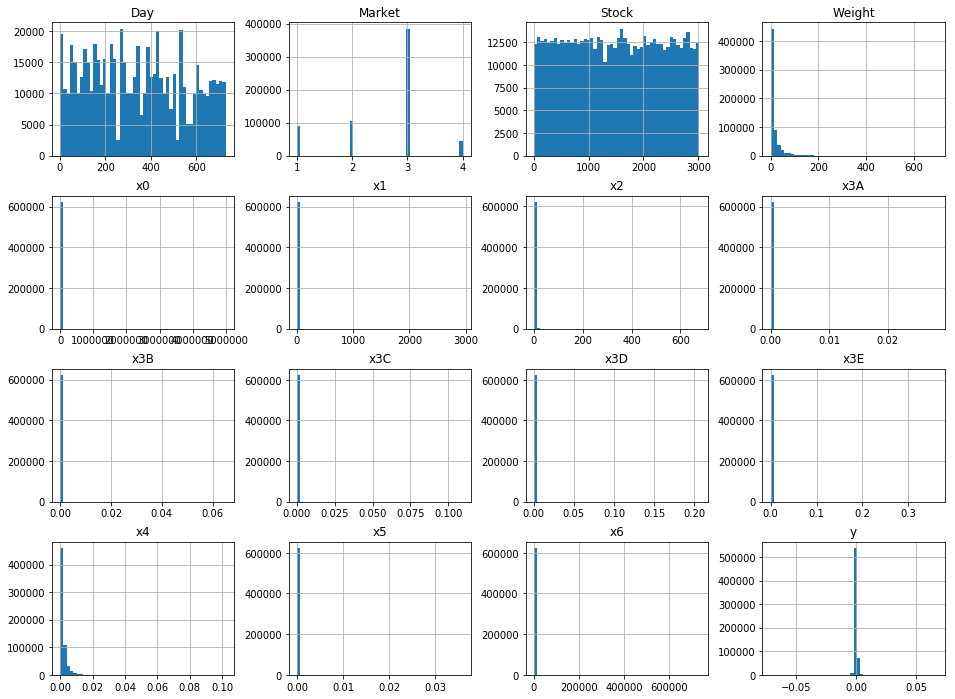

In [12]:
df.hist(bins=50, figsize=(16,12))
plt.show()
plt.close()

### Check the Time Series for the 'y' Parameter

Plot only some random Stocks, one for each Market (e.g. 998, 58, 2441, 2281).

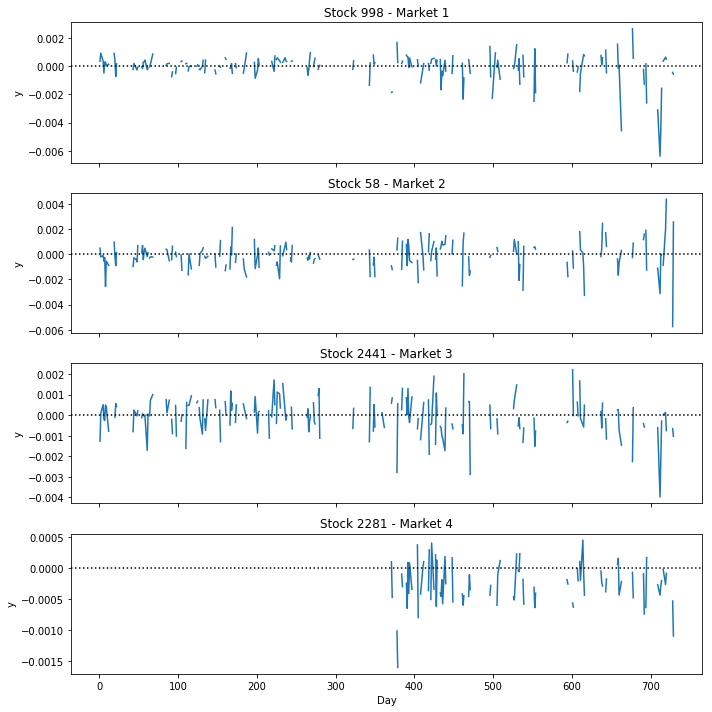

In [13]:
sxs = [998, 58, 2441, 2281]
sns = ['stx1', 'stx2', 'stx3', 'stx4']

for i, sx in enumerate(sxs):
    stx_1 = df.loc[df.Stock == sx]
    stx_1 = stx_1.set_index('Day')
    stx_2 = df_test.loc[df_test.Stock == sx]
    stx_2 = stx_2.set_index('Day')
    globals()[sns[i]] = pd.concat([stx_1, stx_2])
    globals()[sns[i]] = globals()[sns[i]].sort_index()

fig, axs = plt.subplots(nrows=len(sxs), sharex='col', figsize=(10, 10))

for i, sx in enumerate(sxs):
    globals()[sns[i]].plot(y='y', ax=axs[i], legend=None)
    axs[i].set_title('Stock '+str(sxs[i])+' - Market '+str(globals()[sns[i]].Market.iloc[0]))
    axs[i].axhline(y=0, color='k', linestyle=':')
    axs[i].set_ylabel('y')
    
plt.tight_layout()
plt.show()
plt.close()

### Check all the Time Series 
Plot only 2 random Stocks (e.g. 244, 1016).

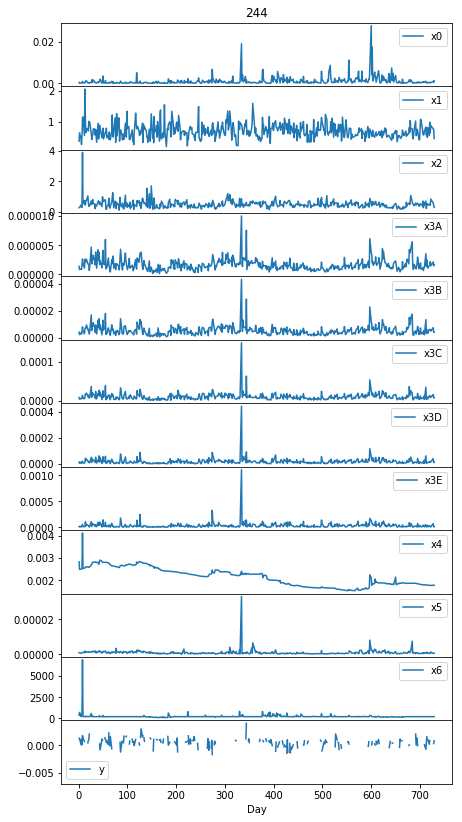

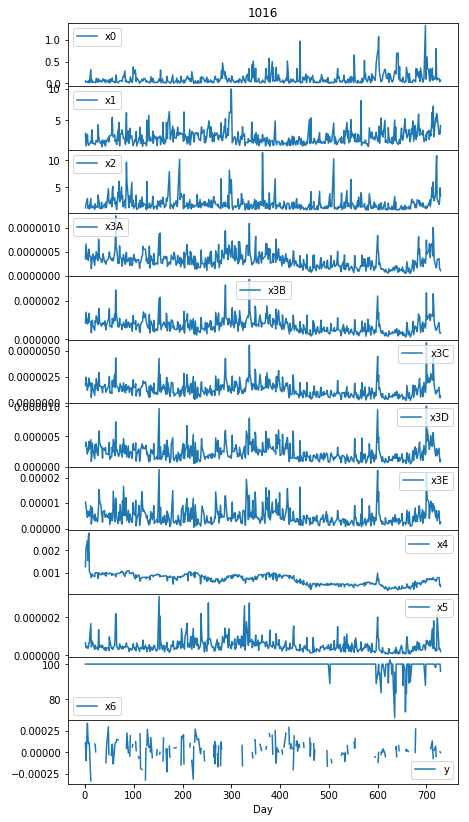

In [14]:
sxs = [244, 1016]
pars = df.columns.tolist()[3:-1]

for sx in sxs:
    fig, ax = plt.subplots(len(pars), 1, sharex=True, figsize=(7, 14))
    plt.subplots_adjust(hspace=0)
    ax[0].set_title(sx)
    stx_1 = df[df.Stock == sx]
    stx_1 = stx_1.set_index('Day')
    stx_2 = df_test[df_test.Stock == sx]
    stx_2 = stx_2.set_index('Day')
    stx = pd.concat([stx_1, stx_2])
    stx = stx.sort_index()
    for i, par in enumerate(pars):
        stx.plot(ax=ax[i], y=par)
    plt.show()
    plt.close()

### Check the Time Series of Stocks where x3A has zero values
Plot only 2 randomly selected Stocks (e.g. 2382, 22)

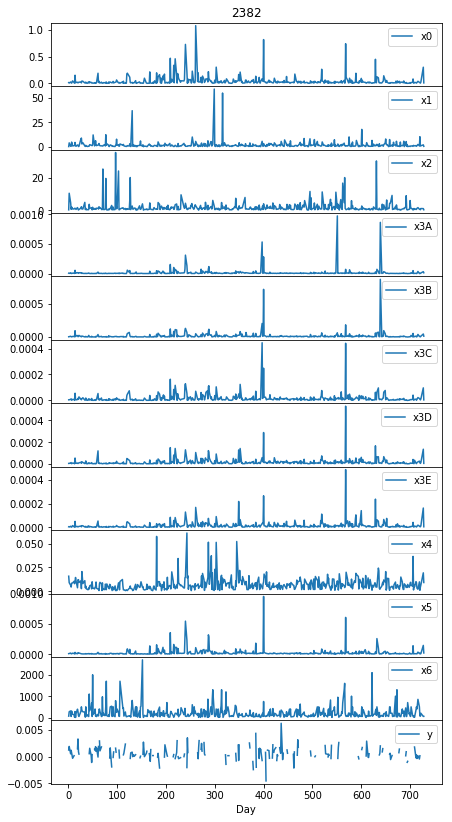

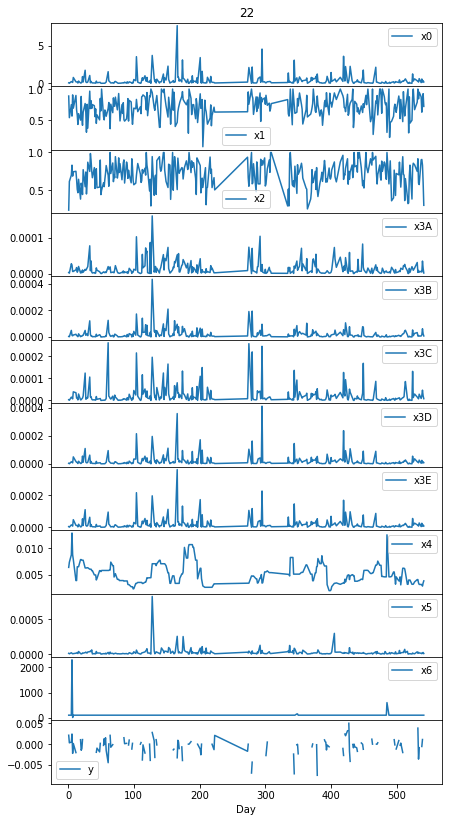

In [15]:
df_z = df[df['x3A'] == 0]
#print(df_z.Stock.unique())

sxs = [2382, 22]
pars = df.columns.tolist()[3:-1]

for sx in sxs:
    fig, ax = plt.subplots(len(pars), 1, sharex=True, figsize=(7, 14))
    plt.subplots_adjust(hspace=0)
    ax[0].set_title(sx)
    stx_1 = df[df.Stock == sx]
    stx_1 = stx_1.set_index('Day')
    stx_2 = df_test[df_test.Stock == sx]
    stx_2 = stx_2.set_index('Day')
    stx = pd.concat([stx_1, stx_2])
    stx = stx.sort_index()
    for i, par in enumerate(pars):
        stx.plot(ax=ax[i], y=par)
    plt.show()
    plt.close()

### Compute Correlation Coefficients for each Stock

We plot a histogram of the distribution of correlation coefficients between each of the parameters and 'y'. 

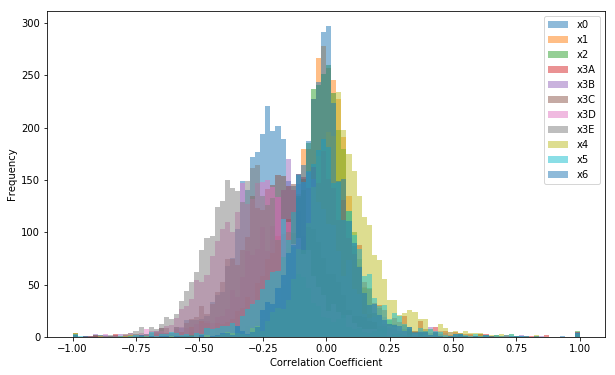

In [16]:
st_nums = set(df.Stock.tolist())
pars = df.columns.tolist()[3:-1]
corr_st = pd.DataFrame(columns=pars)
for stn in st_nums:
    st = df[df.Stock == stn][pars]
    corr = st.corr()
    rw = corr[corr.index == 'y']
    rw.index = [stn]
    corr_st = corr_st.append(rw)

# Plot a histogram of Correlation Coefficients 
ax = corr_st.loc[:, :'x6'].plot.hist(bins=100, alpha=0.5, figsize=(10,6))
ax.set_xlabel('Correlation Coefficient')
plt.show()
plt.close()

### Scatter Plots of Log of Parameters vs. y

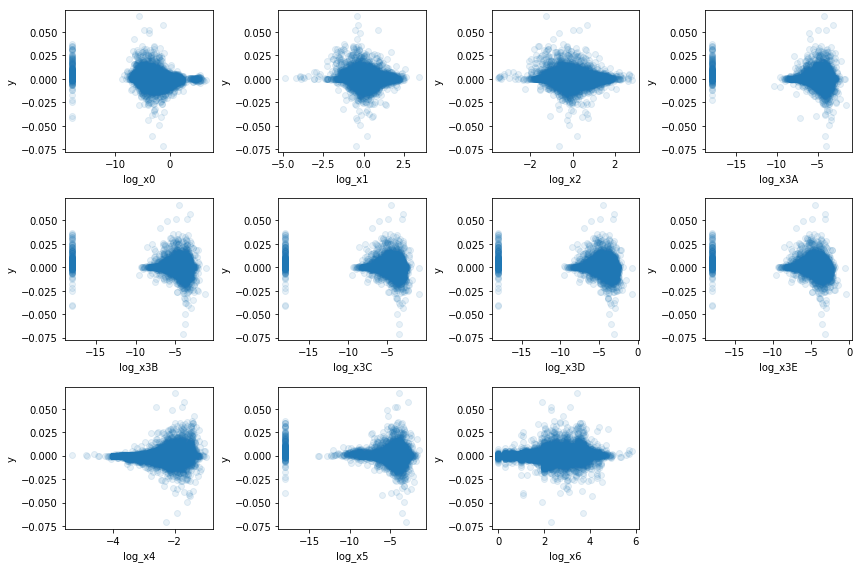

In [17]:
par2 = ['log_x0', 'log_x1', 'log_x2', 'log_x3A', 'log_x3B', 'log_x3C', 
        'log_x3D', 'log_x3E', 'log_x4', 'log_x5', 'log_x6']
for i, par in enumerate(pars[:-1]):
    df[par2[i]] = np.log10(df[par]+1e-18)

fig, axs = plt.subplots(3, 4, figsize=(12, 8))
axs = axs.ravel()
for i, par in enumerate(par2):
    df.plot(x=par, y='y', style='o', alpha=0.1, ax=axs[i], legend=None)
    axs[i].set_ylabel('y')
fig.delaxes(axs[11])
fig.tight_layout()
plt.show()
plt.close()

### Scatter of Parameters in Different Markets

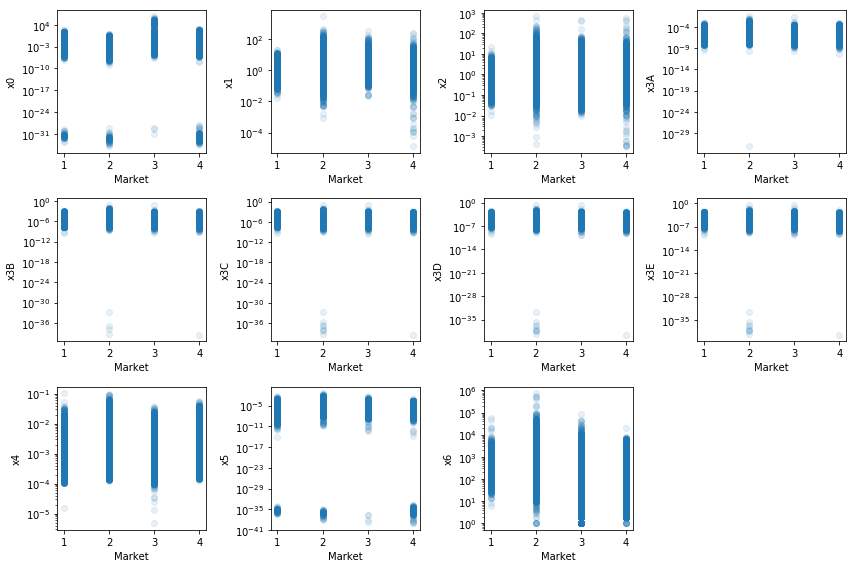

In [21]:
fig, axs = plt.subplots(3, 4, figsize=(12, 8))
axs = axs.ravel()
for i, par in enumerate(pars[:-1]):
    df.plot(x='Market', y=par, style='o', alpha=0.1, ax=axs[i], legend=None)
    axs[i].set_ylabel(par)
    axs[i].set_yscale('log')
fig.delaxes(axs[11])
fig.tight_layout()
plt.show()
plt.close()

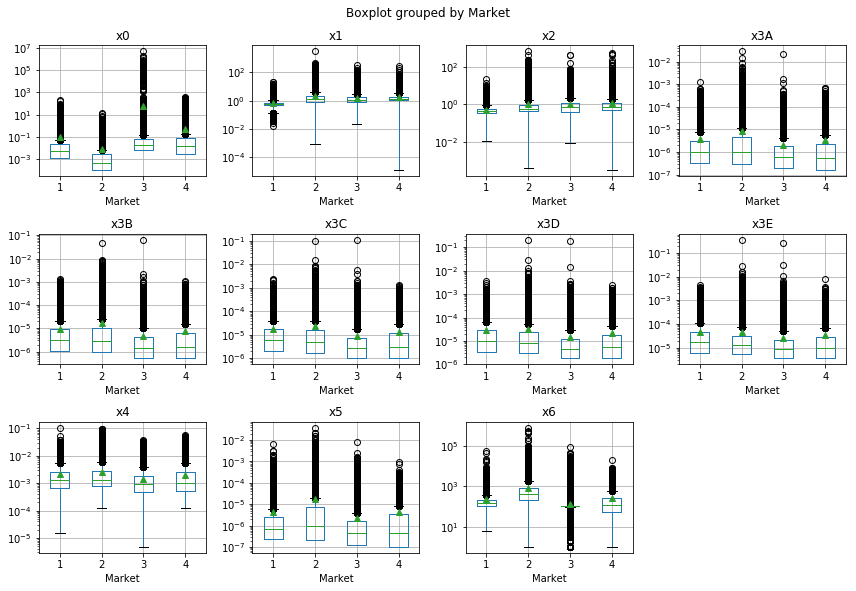

In [39]:
fig, axs = plt.subplots(3, 4, figsize=(12, 8))
axs = axs.ravel()
for i, par in enumerate(pars[:-1]):
    df.boxplot(par, by='Market', ax=axs[i], showmeans=True)
    axs[i].set_yscale('log')
fig.delaxes(axs[11])
fig.suptitle('Boxplot grouped by Market', y=1.02)
fig.tight_layout()
plt.show()
plt.close()

### Look for Correlations

In [40]:
corr_matrix = df.corr()
corr_matrix['y'].sort_values(ascending=False)

y          1.000000
x4         0.184876
log_x4     0.126073
log_x6     0.099430
x6         0.037470
log_x5     0.019535
x5         0.013004
log_x3A    0.010848
Stock      0.004142
x1         0.000911
x2        -0.002578
x0        -0.003346
Day       -0.004684
log_x3B   -0.006272
x3A       -0.024256
x3B       -0.028774
log_x3C   -0.031143
Weight    -0.035346
x3C       -0.038501
x3D       -0.047488
log_x2    -0.053164
x3E       -0.054529
log_x3D   -0.062272
log_x1    -0.063839
Market    -0.066614
log_x3E   -0.100472
log_x0    -0.215734
Name: y, dtype: float64

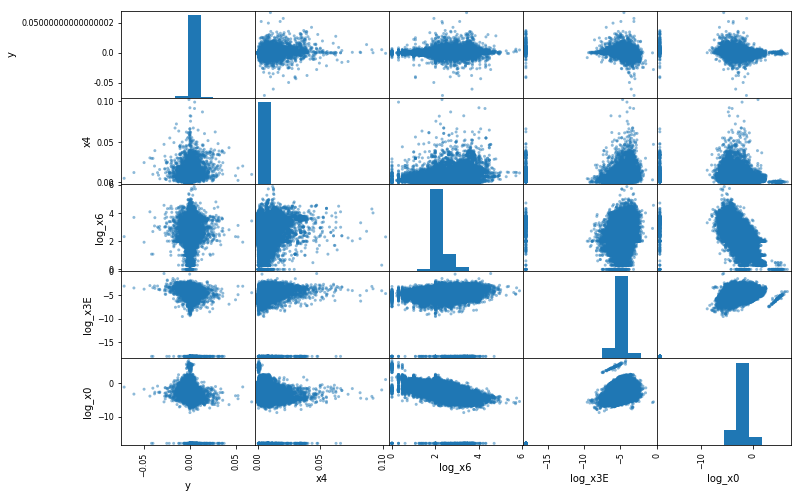

In [42]:
interest_feats = ['y', 'x4', 'log_x6', 'log_x3E', 'log_x0']
scatter_matrix(df[interest_feats], figsize=(12, 8))
plt.show()

### Check Correlations in the 4 Markets separately
Plot the distribution of correlation coefficients for each Market.

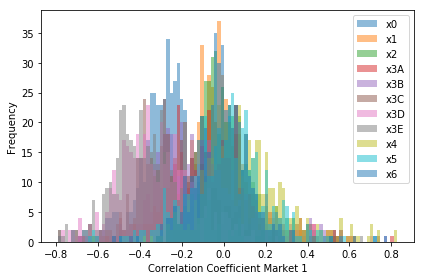

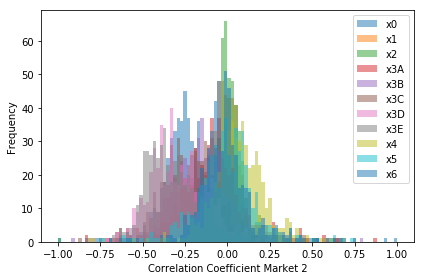

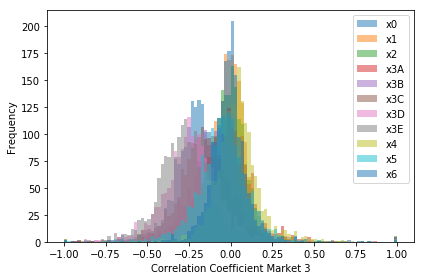

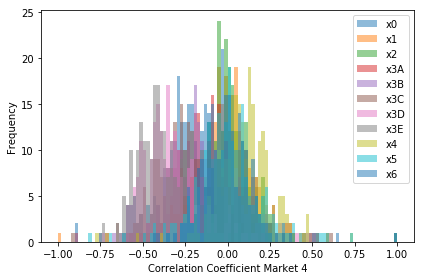

In [43]:
for j in list(range(5))[1:]:
    stn_m = set(df.Stock[df.Market == j].tolist())
    corr_st = pd.DataFrame(columns=pars)
    for stn in stn_m:
        st = df[df.Stock == stn][pars]
        corr = st.corr()
        rw = corr[corr.index == 'y']
        rw.index = [stn]
        corr_st = corr_st.append(rw)
    # Plot a histogram 
    ax = corr_st.loc[:, :'x6'].plot.hist(bins=100, alpha=0.5)
    ax.set_xlabel('Correlation Coefficient Market '+str(j))
    plt.tight_layout()
    #plt.savefig('Plots/Hist_M'+str(j)+'_corr_coeff.png')
    plt.show()
    plt.close()

## XGBoost Model
First we try to use all the information, including the log of parameters.

### Data Preparation

In [45]:
df = df.dropna()

# Split Dataframe in X and y
X = df.drop(['y','Weight'], axis=1)
y = df['y']

# Split the Data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size, 
                                                    random_state=seed
                                                    )

print('Size of training set: \t{0:d}'.format(X_train.shape[0]))
print('Size of test set: \t{0:d}'.format(X_test.shape[0]))

Size of training set: 	417918
Size of test set: 	205841


### Define the Model and Fit It on the Training Dataset

In [48]:
model = XGBRegressor(n_estimators=300, max_depth=7, colsample_bytree = 0.8)

# Define an evaluation subset to monitor performance and set early stopping 
eval_set = [(X_test, y_test)]

# Fit model on training data
model.fit(X_train, y_train, eval_metric="logloss", eval_set=eval_set, verbose=True)
#[299]	validation_0-logloss:-0.00132

[0]	validation_0-logloss:0.597866
[1]	validation_0-logloss:0.519247
[2]	validation_0-logloss:0.453417
[3]	validation_0-logloss:0.397664
[4]	validation_0-logloss:0.350014
[5]	validation_0-logloss:0.30899
[6]	validation_0-logloss:0.273455
[7]	validation_0-logloss:0.242521
[8]	validation_0-logloss:0.215476
[9]	validation_0-logloss:0.191747
[10]	validation_0-logloss:0.170863
[11]	validation_0-logloss:0.152434
[12]	validation_0-logloss:0.136135
[13]	validation_0-logloss:0.12169
[14]	validation_0-logloss:0.108867
[15]	validation_0-logloss:0.097466
[16]	validation_0-logloss:0.087316
[17]	validation_0-logloss:0.078269
[18]	validation_0-logloss:0.070197
[19]	validation_0-logloss:0.062988
[20]	validation_0-logloss:0.056546
[21]	validation_0-logloss:0.050783
[22]	validation_0-logloss:0.045626
[23]	validation_0-logloss:0.041008
[24]	validation_0-logloss:0.036871
[25]	validation_0-logloss:0.033163
[26]	validation_0-logloss:0.029838
[27]	validation_0-logloss:0.026855
[28]	validation_0-logloss:0.0241

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Compute Model Predictions for the Test Dataset

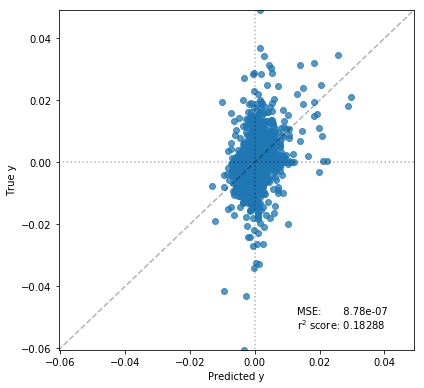

In [51]:
predictions = model.predict(X_test)

# Plot comparison of true values with model predictions
typlot(predictions)

In [52]:
# Print scores
print('MSE:\t\t', mean_squared_error(y_test, predictions))
print('MAE:\t\t', mean_absolute_error(y_test, predictions))
print('r^2 score:\t', r2_score(y_test, predictions)) 
print('Expl. Var.:\t', explained_variance_score(y_test, predictions)) # 1.0 is Good, lower are bad

MSE:		 8.779173278839009e-07
MAE:		 0.00036396892415196567
r^2 score:	 0.1828796689582355
Expl. Var.:	 0.18289174441183265


### Feature Importance

In [60]:
for f, fimp in enumerate(model.feature_importances_):
    print(X.columns[f]+':\t'+str(fimp))

Market:	0.02835191
Day:	0.08337842
Stock:	0.055892218
x0:	0.077859536
x1:	0.08310789
x2:	0.063304834
x3A:	0.06893194
x3B:	0.061573423
x3C:	0.050589763
x3D:	0.05291635
x3E:	0.044313386
x4:	0.0929012
x5:	0.07477546
x6:	0.041662157
log_x0:	0.011254193
log_x1:	0.008765285
log_x2:	0.012282221
log_x3A:	0.011200086
log_x3B:	0.009901525
log_x3C:	0.0084947515
log_x3D:	0.0091981385
log_x3E:	0.008927605
log_x4:	0.015041662
log_x5:	0.014175955
log_x6:	0.011200086


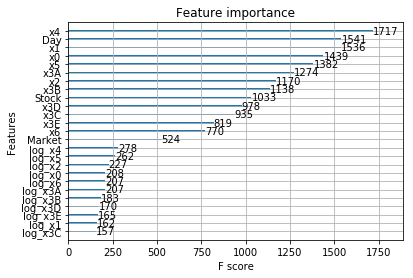

In [61]:
plot_importance(model)
plt.show()
plt.close()

Then we try to reduce the number of parameters. Here, we try to use only the log of parameters.

In [62]:
# Split Dataframe in X and y
X = df.drop(['x0', 'x1', 'x2', 'x3A', 'x3B', 'x3C', 
             'x3D', 'x3E', 'x4', 'x5', 'x6', 'y','Weight'], axis=1)
y = df['y']

# Split the Data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size, 
                                                    random_state=seed
                                                    )

print('Size of training set: \t{0:d}'.format(X_train.shape[0]))
print('Size of test set: \t{0:d}'.format(X_test.shape[0]))

Size of training set: 	417918
Size of test set: 	205841


### Define the Model and Fit It on the Training Dataset

In [63]:
model = XGBRegressor(n_estimators=300, max_depth=7, colsample_bytree = 0.8)

# Define an evaluation subset to monitor performance and set early stopping 
eval_set = [(X_test, y_test)]

# Fit model on training data
model.fit(X_train, y_train, eval_metric="logloss", eval_set=eval_set, verbose=True)

[0]	validation_0-logloss:0.597866
[1]	validation_0-logloss:0.519247
[2]	validation_0-logloss:0.453417
[3]	validation_0-logloss:0.397664
[4]	validation_0-logloss:0.350014
[5]	validation_0-logloss:0.30899
[6]	validation_0-logloss:0.273455
[7]	validation_0-logloss:0.242521
[8]	validation_0-logloss:0.215476
[9]	validation_0-logloss:0.191747
[10]	validation_0-logloss:0.170863
[11]	validation_0-logloss:0.152434
[12]	validation_0-logloss:0.136135
[13]	validation_0-logloss:0.12169
[14]	validation_0-logloss:0.108867
[15]	validation_0-logloss:0.097466
[16]	validation_0-logloss:0.087316
[17]	validation_0-logloss:0.078269
[18]	validation_0-logloss:0.070197
[19]	validation_0-logloss:0.062988
[20]	validation_0-logloss:0.056546
[21]	validation_0-logloss:0.050783
[22]	validation_0-logloss:0.045626
[23]	validation_0-logloss:0.041008
[24]	validation_0-logloss:0.036871
[25]	validation_0-logloss:0.033163
[26]	validation_0-logloss:0.029838
[27]	validation_0-logloss:0.026856
[28]	validation_0-logloss:0.0241

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Compute Model Predictions for the Test Dataset

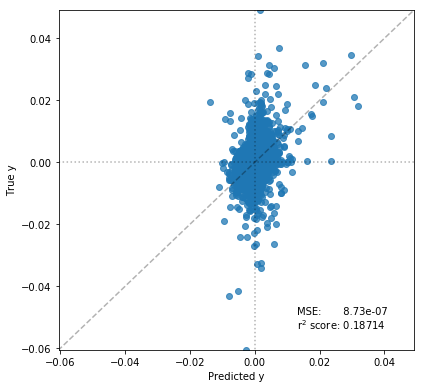

In [64]:
predictions = model.predict(X_test)

# Plot comparison of true values with model predictions
typlot(predictions)

In [65]:
# Print scores
print('MSE:\t\t', mean_squared_error(y_test, predictions))
print('MAE:\t\t', mean_absolute_error(y_test, predictions))
print('r^2 score:\t', r2_score(y_test, predictions)) 
print('Expl. Var.:\t', explained_variance_score(y_test, predictions)) # 1.0 is Good, lower are bad

MSE:		 8.733403920801991e-07
MAE:		 0.00036389441699997055
r^2 score:	 0.1871396455873473
Expl. Var.:	 0.1871472812998104


### Feature Importance

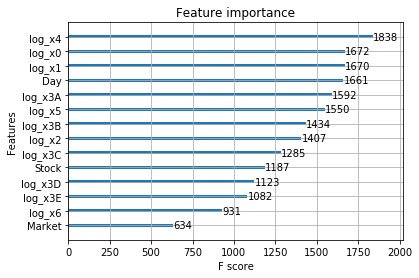

In [66]:
plot_importance(model)
plt.show()
plt.close()